# Retrieve the data files for reading in

In [1]:
# Import matplot for plotting later on
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Specify the path to our data
dataPath = "../../data/"

In [3]:
# Walk the data folder, returning a list of all the files
import os
rasterBin = []
for root, dirs, files in os.walk(dataPath, topdown=False):
   for file in files:
        if ".hdr" not in file:
            rasterBin.append(os.path.join(dataPath, file))

print("files retrieved")

files retrieved


# Read in the original image and truth labeled images for classification

In [4]:
# Library for working with raster images
import rasterio
import numpy as np
from rasterio import plot

In [5]:
import pandas as pd
data_frame = pd.DataFrame(columns=(
    'coastal_aerosol',
    'blue',
    'green',
    'red',
    'vre1',
    'vre2',
    'vre3',
    'nir',
    'narrow_nir',
    'water_vapour',
    'swir_cirrus',
    'swir2', 
    'label_water_val',
    'label_water_bool', 
    'label_river_val', 
    'label_river_bool',
    'label_broadleaf_val',
    'label_broadleaf_bool',
    'label_shrub_val',
    'label_shrub_bool'))

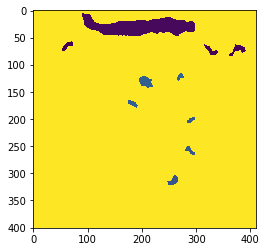

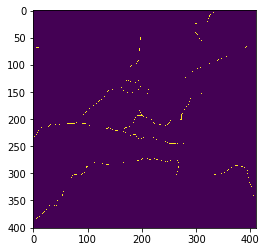

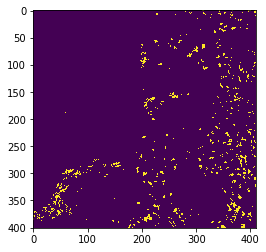

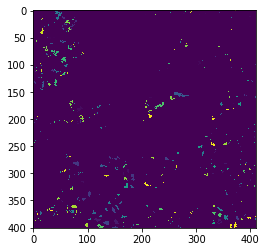

In [6]:
for raster in rasterBin:
    if "S2A.bin_4x.bin_sub.bin" in raster:
        
        dataset = rasterio.open(raster)     
        for idx in dataset.indexes:
            """
            reads in the current band which is a mat of 401, 410 and ravels it
            storing the result in the current column
            """ 
            data_frame.iloc[:,idx-1] = dataset.read(idx).ravel()
            
    elif "WATERSP.tif_project_4x.bin_sub.bin" in raster:
        water = rasterio.open(raster).read(1)
        data_frame['label_water_val'] = water.ravel()
        data_frame['label_water_bool'] = data_frame['label_water_val'] != 128
        
    elif "RiversSP.tif_project_4x.bin_sub.bin" in raster:
        river = rasterio.open(raster).read(1)
        data_frame['label_river_val'] = river.ravel()
        data_frame['label_river_bool'] = data_frame['label_river_val'] == 1.0
    
    elif "BROADLEAF_SP.tif_project_4x.bin_sub.bin" in raster:
        broadleaf = rasterio.open(raster).read(1)
        data_frame['label_broadleaf_val'] = broadleaf.ravel()
        data_frame['label_broadleaf_bool'] = data_frame['label_broadleaf_val'] == 1.0
    
    elif "SHRUB_SP.tif_project_4x.bin_sub.bin" in raster:
        shrub = rasterio.open(raster).read(1)
        data_frame['label_shrub_val'] = shrub.ravel()
        # yet to decode the shrub values boolean correspondance

# vri_s2_objid2.tif_project_4x.bin_sub.bin
## S2A.bin_4x.bin_sub.bin
## BROADLEAF_SP.tif_project_4x.bin_sub.bin
## WATERSP.tif_project_4x.bin_sub.bin
# MIXED_SP.tif_project_4x.bin_sub.bin
## SHRUB_SP.tif_project_4x.bin_sub.bin
# vri_s3_objid2.tif_project_4x.bin_sub.bin
## RiversSP.tif_project_4x.bin_sub.bin
# L8.bin_4x.bin_sub.bin
# CONIFER_SP.tif_project_4x.bin_sub.bin
# HERB_GRAS_SP.tif_project_4x.bin_sub.bin
# CCUTBL_SP.tif_project_4x.bin_sub.bin
# EXPOSED_SP.tif_project_4x.bin_sub.bin
plot.show(water)
plot.show(river)
plot.show(broadleaf)
plot.show(shrub)

In [10]:
# example of finding subsets based on two seperate values
data_frame[(data_frame['label_water_bool'] == True) & (data_frame['label_river_bool'] == True)]

,coastal_aerosol,blue,green,red,vre1,vre2,vre3,nir,narrow_nir,water_vapour,swir_cirrus,swir2,label_water_val,label_water_bool,label_river_val,label_river_bool,label_broadleaf_val,label_broadleaf_bool,label_shrub_val,label_shrub_bool
56778,964.559998,746.880005,688.039978,443.279999,794.840027,1636.920044,1891.800049,1843.079956,779.960022,8.44,996.440002,460.440002,45.0,True,1.0,True,0.0,False,0.0,NaN


In [11]:
X_true = data_frame[data_frame['label_water_bool'] == True]
X_false = data_frame[data_frame['label_water_bool'] == False].sample(len(X_true))

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
undersample_water_frames = [X_true, X_false]
X_full = pd.concat(undersample_water_frames) # Concat the undersampled true and false pixels
X = X_full.loc[:, : 'swir2'] # only considers the columns up to swir2

In [14]:
X_norm = scaler.fit_transform(X)

In [15]:
y = X_full['label_water_bool']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=0, test_size=0.2)

In [17]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier(random_state=42, verbose=0, warm_start=True)
y_pred = sgd_classifier.fit(X_train, y_train).predict(X_test)

In [19]:
print("Test score: {:.2f}".format(sgd_classifier.score(X_test, y_test)))

Test score: 0.93


In [20]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [21]:
conf_matrix

array([[1319,   54],
       [ 124, 1153]])